In [32]:
import pandas as pd
import numpy as np
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
brown_ic = wordnet_ic.ic('ic-brown.dat')
import matplotlib as plt
import os
from collections import Counter
from scipy.interpolate import interp1d
from nltk.corpus import verbnet
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import classification_report
tqdm.pandas()
scale_converter = interp1d([0,6],[0,10])

In [33]:
def get_classid(verb):
    # print(verb)
    classid = verbnet.classids(lemma = verb)
    # print(classid)
    return classid
    
def get_lemmas(verb):
    classid = get_classid(verb)
    if len(classid) > 0:
        lemmas = verbnet.lemmas(classid[0])
        return lemmas
    else:
        return "-1"

def get_frames(verb):
    classid = get_classid(verb)
    if len(classid) > 0:
        frames = []
        for item in verbnet.frames(classid[0]):
            # print(item)
            frames.append(item["description"]["primary"])
        return frames
    else:
        return ["None"]

def get_unique_frames(classid):
    frames = []
    for item in verbnet.frames(classid[0]):
        # print(item)
        frames.append(item["description"]["primary"])
    return pd.unique(frames)

*Verbs that participate in this alternation include scatter, pump, hang, drizzle, and cram, all of which are verbs that semantically involve a type of placement or covering. Because of their shared syntactic behaviors, these verbs are grouped together in the Spray-‐9.7 class.*

Share syntactic behaviors -> grouped together in classes -> check shared classes?

# SimVerb:

In [34]:
simverb = pd.read_csv("../data/SimVerb-3500.txt",sep='\t', header = None)

simverb.columns = ["word1","word2","pos","sv_score",'relation']

print(simverb)

            word1     word2 pos  sv_score        relation
0            take    remove   V      6.81        SYNONYMS
1            walk     trail   V      4.81      COHYPONYMS
2            feed    starve   V      1.49        ANTONYMS
3           shine    polish   V      7.80        SYNONYMS
4       calculate       add   V      5.98  HYPER/HYPONYMS
...           ...       ...  ..       ...             ...
3495       impose     cheat   V      1.16            NONE
3496        rebel   protest   V      7.64  HYPER/HYPONYMS
3497  collaborate  conspire   V      4.23            NONE
3498     conspire   protest   V      1.83            NONE
3499      protest   release   V      1.16            NONE

[3500 rows x 5 columns]


In [35]:
# simverb_full_ratings = pd.read_csv("../data/SimVerb-3520-annotator-ratings.csv", header = None)
# # simverb.columns = ["word1","word2","pos","sv_score",'relation']
# indexes = range(0,702, 1)
# cols = ["r"+ str(rater) for rater in indexes]
# colsets = ["r"+ str(rater) for rater in indexes]
# cols.insert(0, "word2")
# cols.insert(0, "word1")
# simverb_full_ratings.columns = cols
# print(simverb_full_ratings)

In [36]:
simverb_ratings = pd.read_csv("../data/SimVerb-3500-ratings.csv")

# print(simverb_ratings)

simverb_ratings["mean_rating"] = scale_converter(simverb_ratings[['r1','r2','r3','r4','r5','r6','r7','r8','r9','r10']].mean(axis = 1))
simverb_ratings["sd_rating"] = simverb_ratings[['r1','r2','r3','r4','r5','r6','r7','r8','r9','r10']].std(axis = 1)

## Background: 
- Meaning as inherent in word relations, meaning as derived from statistical regularities -> distributional semantics theory of word meaning


- Verbs and nouns are conceptually different, which may be reflected in age of acquisition for English speaking babies 
- Noun bias (see Ch11 from https://langcog.github.io/wordbank-book/categories-syntactic.html)
- Nouns seem to be more "indexical" in nature, with a given label (usually) mapping directly to a object, or more concrete aspect, while verbs are more relational (Gentner, 1982)
- Other considerations: syntactic position, morphology


- This difference is also reflected in distributional semantics models
- Distributional semantics models as harnessing the co-occurrence statistics to capture word meaning
- Variety of models perform well on different tasks, however, recently developed gold standards (simlex, simverb) have shown that their performance greatly differs based on part of speech


- What differentiates these two POS in their representation? 

## Research question:
- What is the relationship between syntax and semantics for verb understanding? 
- How do syntax and semantics interact regarding verb representation?
- How do these models reflect our own linguistic processing of verbs?

General question: See above ^

Research question: Does syntactic and semantic info impact people's performance on human judgement of similarity?

-> show specifically these different types of information --> control condition (has syntax but not informative about their meaning representation)

-> inter annotater agreement

Corpus data -> frequencies of ()

Google ngrams -> syntactic version (syntgram), checking syntactic frame (counts)

## Implementation / approach:
- Use WordNet and VerbNet as *what* -> syntactic reference point?
- POS disambiguation: number of different potential parts of speech for a given word -> entropy of potential POS?
- Sense disambiguation: 1) number of different senses, 2) average similarity to other senses
- *VerbNet* something with subcat bias?

### Other thoughts:
- Lemmas and amount of verb frames?
- Entailment environment

#### Out of the scope of this study:
- Comparison between languages with and without noun bias

In [37]:
# Cases when word not in WN?

def potential_pos(word):
    pos = []
    for sense in wn.synsets(word):
        pos.append(sense.pos())
    return Counter(pos)
        
    
def num_v_senses(word):
#     print(wn.synsets(word, pos = wn.VERB))
    num_senses = len(wn.synsets(word, pos = wn.VERB))
#     print(num_senses)
    return num_senses

In [38]:
# simverb["w1_pos"] = simverb['word1'].progress_apply(potential_pos)
simverb["w1_num_v_senses"] = simverb['word1'].progress_apply(num_v_senses)
# simverb["w2_pos"] = simverb['word2'].progress_apply(potential_pos)
simverb["w2_num_v_senses"] = simverb['word2'].progress_apply(num_v_senses)

100%|██████████| 3500/3500 [00:00<00:00, 142458.50it/s]


In [39]:
# simverb["w1_lemmas"] = simverb["word1"].progress_apply(get_lemmas)
# simverb["w2_lemmas"] = simverb["word2"].progress_apply(get_lemmas)
simverb["w1_frames"] = simverb["word1"].progress_apply(get_frames)
simverb["w2_frames"] = simverb["word2"].progress_apply(get_frames)

100%|██████████| 3500/3500 [00:01<00:00, 2068.20it/s]


In [40]:
sv_ratings = simverb_ratings[["word1", "word2","mean_rating","sd_rating"]]

# print(simverb_ratings)

sv_set = pd.merge(simverb, sv_ratings, how = "left", on = ["word1", "word2"])

In [41]:
print(sv_set)

            word1     word2 pos  sv_score        relation  w1_num_v_senses  \
0            take    remove   V      6.81        SYNONYMS               42   
1            walk     trail   V      4.81      COHYPONYMS               10   
2            feed    starve   V      1.49        ANTONYMS               12   
3           shine    polish   V      7.80        SYNONYMS               10   
4       calculate       add   V      5.98  HYPER/HYPONYMS                6   
...           ...       ...  ..       ...             ...              ...   
3495       impose     cheat   V      1.16            NONE                3   
3496        rebel   protest   V      7.64  HYPER/HYPONYMS                2   
3497  collaborate  conspire   V      4.23            NONE                2   
3498     conspire   protest   V      1.83            NONE                2   
3499      protest   release   V      1.16            NONE                3   

      w2_num_v_senses                                          

In [42]:
data_frames = np.unique(sv_set[["w1_frames","w2_frames"]].values)

unique_frames = []

for item in data_frames:
    for frame in item:
        unique_frames.append(frame)

unique_frames = np.unique(unique_frames)
print(unique_frames)
print(len(unique_frames))

# One-hot encoding? Index coding? Number of syntax frames?


sv_set["shared_frames"] = sv_set.apply(lambda row: len(list(set(row.w1_frames) & set(row.w2_frames))), axis = 1)


['(SUBCAT ADL)' '(SUBCAT MP)' 'ADJP' 'ADJP-PP' 'ADVP-PRED'
 'Attribute Object Possessor-Attribute Factoring Alternation'
 'Basic Intransitive' 'Basic Transitive' 'Benefactive Alternation'
 'Characteristic Property of Instrument' 'Conative' 'Dative' 'FOR-TO-INF'
 'HOW-S' 'HOW-TO-INF' 'ING-AC' 'ING-NP-OMIT' 'ING-SC/BE-ING'
 'ING-SC/BE-ING-SC' 'Infinitival Copular Clause'
 'Instrument Subject Alternation' 'Intransitive'
 'Location Subject Alternation' 'Locative Inversion'
 'Locative Preposition Drop' 'Locatum Subject Alternation'
 'Material/Product Alternation Transitive' 'Middle Construction' 'NP'
 'NP-ADJP' 'NP-ADJP-PP' 'NP-ADJP-PRED' 'NP-ADVP-PRED' 'NP-HOW-S'
 'NP-HOW-TO-INF' 'NP-ING-SC' 'NP-NP' 'NP-NP-PP' 'NP-NP-PRED' 'NP-P-ING'
 'NP-P-ING-AC' 'NP-P-ING-OC' 'NP-P-ING-SC' 'NP-PP' 'NP-PP-PP' 'NP-QUOT'
 'NP-S' 'NP-TO-INF-OC' 'NP-TOBE' 'NP-VEN-NP-OMIT' 'NP-WH-S' 'NP-WH-TO-INF'
 'NP-WHAT-S' 'NP-WHAT-TO-INF' 'None' 'P-ING-SC' 'P-NP-ING' 'P-NP-TO-INF'
 'P-POSSING' 'P-WH-S' 'P-WH-TO-INF' 'P-W

In [43]:
# sv_set["w1_frame_count"] = sv_set["w1_frames"].apply(len)
# sv_set["w2_frame_count"] = sv_set["w2_frames"].apply(len)
# relations = np.sort(pd.unique(sv_set["relation"]))
# keys = list(range(0, len(relations)))
# relation_dict = {relations[i]: keys[i] for i in range(len(relations))}
# sv_set["relation_index"] = sv_set["relation"].map(relation_dict)
# print(sv_set)

In [44]:
# sv_set.to_csv("../data_output/simverb_processed.csv", index = False)

In [45]:
sv_set.describe()

,sv_score,w1_num_v_senses,w2_num_v_senses,mean_rating,sd_rating,shared_frames
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,4.291554,7.957143,8.180286,4.311095,1.330124,1.044286
std,2.652621,8.775755,9.072778,2.661175,0.511671,1.667240
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.830000,3.000000,3.000000,1.833333,0.971825,0.000000
50%,4.320000,5.000000,5.000000,4.333333,1.370320,0.000000
75%,6.340000,10.000000,10.000000,6.333333,1.712698,2.000000
max,9.960000,59.000000,59.000000,10.000000,2.838231,25.000000


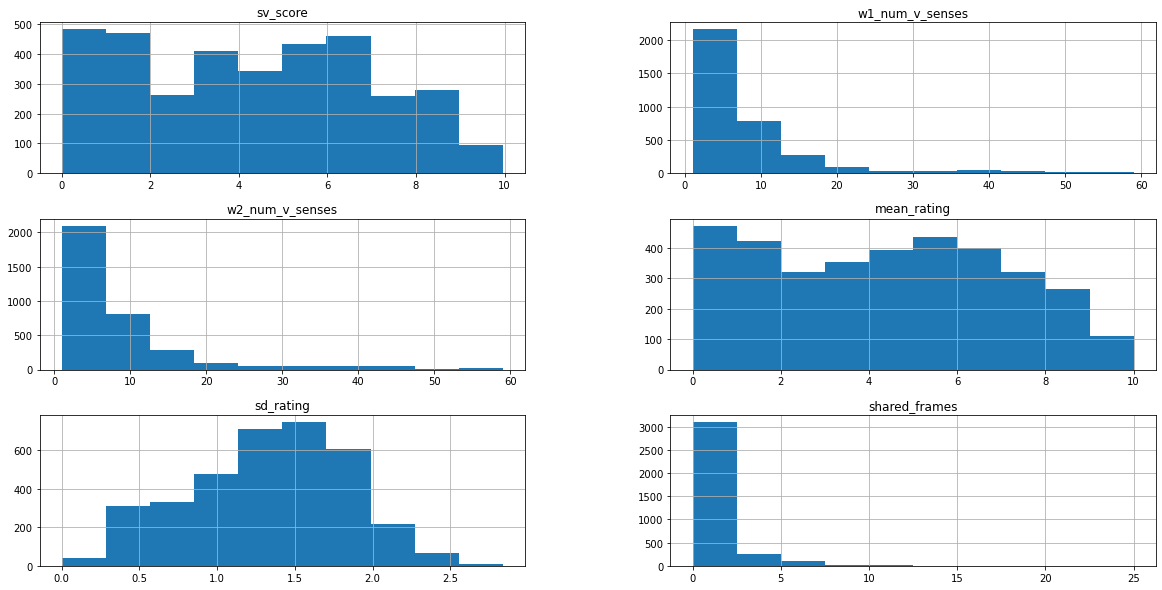

In [46]:
sv_set.hist(figsize=(20,10));

In [47]:
# inputs = sv_set[["relation_index","w1_frame_count","w2_frame_count","w1_num_v_senses","w2_num_v_senses", "shared_frames"]]

# targets = sv_set[["sd_rating"]]

# mse_full = []

# for i in range(0,50):

#     (train_inputs, test_inputs, train_targets, test_targets) = train_test_split(inputs.to_numpy(), targets.to_numpy(), test_size=0.33)

#     reg = LinearRegression().fit(train_inputs, train_targets)

#     predicted_targets = reg.predict(test_inputs)

#     mse_full.append(mean_squared_error(test_targets, predicted_targets))

# ###########################################################################################

# inputs = sv_set[["w1_frame_count","w2_frame_count","w1_num_v_senses","w2_num_v_senses", "shared_frames"]]

# targets = sv_set[["sd_rating"]]

# mse_frames_senses = []

# for i in range(0,50):

#     (train_inputs, test_inputs, train_targets, test_targets) = train_test_split(inputs.to_numpy(), targets.to_numpy(), test_size=0.33)

#     reg = LinearRegression().fit(train_inputs, train_targets)

#     predicted_targets = reg.predict(test_inputs)
    
#     mse_frames_senses.append(mean_squared_error(test_targets, predicted_targets))

# ########################################################################################

# inputs = sv_set[["w1_num_v_senses","w2_num_v_senses"]]

# targets = sv_set[["sd_rating"]]

# mse_senses = []

# for i in range(0,50):

#     (train_inputs, test_inputs, train_targets, test_targets) = train_test_split(inputs.to_numpy(), targets.to_numpy(), test_size=0.33)

#     reg = LinearRegression().fit(train_inputs, train_targets)

#     predicted_targets = reg.predict(test_inputs)

#     mse_senses.append(mean_squared_error(test_targets, predicted_targets))


# ########################################################################################

# inputs = sv_set[["w1_frame_count","w2_frame_count", "shared_frames"]]

# targets = sv_set[["sd_rating"]]

# mse_frames = []

# for i in range(0,50):

#     (train_inputs, test_inputs, train_targets, test_targets) = train_test_split(inputs.to_numpy(), targets.to_numpy(), test_size=0.33)

#     reg = LinearRegression().fit(train_inputs, train_targets)

#     predicted_targets = reg.predict(test_inputs)

#     mse_frames.append(mean_squared_error(test_targets, predicted_targets))

# ########################################################################################

# inputs = sv_set[["shared_frames"]]

# targets = sv_set[["sd_rating"]]

# mse_shared_frames = []

# for i in range(0,50):

#     (train_inputs, test_inputs, train_targets, test_targets) = train_test_split(inputs.to_numpy(), targets.to_numpy(), test_size=0.33)

#     reg = LinearRegression().fit(train_inputs, train_targets)

#     predicted_targets = reg.predict(test_inputs)

#     mse_shared_frames.append(mean_squared_error(test_targets, predicted_targets))

# results_df = pd.DataFrame({"Full predictors": [np.mean(mse_full)], 
#                             "Senses and Frames": [np.mean(mse_frames_senses)], 
#                             'Senses': [np.mean(mse_senses)], 
#                             'Frames': [np.mean(mse_frames)],
#                             'Shared frames':[np.mean(mse_shared_frames)]})

# print(results_df)


In [48]:
# Train memory-based learner?

# inputs = sv_set[["relation_index","w1_frame_count","w2_frame_count","w1_num_v_senses","w2_num_v_senses"]]

# targets = sv_set[["sd_rating"]]

# mse_svr = []

# for i in range(0,50):

#     (train_inputs, test_inputs, train_targets, test_targets) = train_test_split(inputs.to_numpy(), targets.to_numpy(), test_size=0.33)

#     svr_rbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)

#     svr_rbf_fitted = svr_rbf.fit(train_inputs, train_targets.ravel())

#     predicted_targets = svr_rbf_fitted.predict(test_inputs)
#     mse_svr.append(mean_squared_error(predicted_targets, test_targets.ravel()))

# print(np.mean(mse_svr))

# parameters = {"n_neighbors": [3,5,7,9],
#               "weights": ["uniform", "distance"],
#               "algorithm": ["auto","ball_tree","kd_tree", "brute"],
#               "metric": ["euclidean","manhattan","minkowski"]}


# knclf = KNeighborsClassifier()

# gridsearch = GridSearchCV(knclf,
#                           parameters,
#                           cv = 5)

# # print(test_targets.shape)

# knclf_fitted = gridsearch.fit(train_inputs, train_targets.ravel())

# predicted_targets = knclf_fitted.predict(test_inputs)
# print(classification_report(test_targets, predicted_targets))


In [49]:
# Context -- should match, check within-frame vs different-frame comparison
sv_set["w1_frames"] = sv_set.apply(lambda row: pd.unique(list(set(row.w1_frames))), axis = 1)
sv_set["w2_frames"] = sv_set.apply(lambda row: pd.unique(list(set(row.w2_frames))), axis = 1)

frames_to_check = ['Basic Intransitive','Basic Transitive','Benefactive Alternation','Conative','Dative','Infinitival Copular Clause','Instrument Subject Alternation','Intransitive','Location Subject Alternation','Locative Inversion','Locative Preposition Drop','Locatum Subject Alternation','Material/Product Alternation Transitive','Middle Construction','Simple Reciprocal Intransitive','Simple Reciprocal Transitive','There-insertion','Together Reciprocal Alternation Intransitive','Together Reciprocal Alternation Transitive','Transitive','Understood Reciprocal Object','Unintentional Interpretation of Object','Unspecified Object','Unspecified Reflexive Object','With Preposition Drop']


for frame in unique_frames:
    sv_set[frame] = sv_set.apply(lambda row: ((frame in list(set(row.w1_frames))) & (frame in list(set(row.w2_frames)))), axis = 1)

In [50]:
sv_set.head()

,word1,word2,pos,sv_score,relation,w1_num_v_senses,w2_num_v_senses,w1_frames,w2_frames,mean_rating,...,Transitive,Understood Reciprocal Object,Unintentional Interpretation of Object,Unspecified Object,Unspecified Reflexive Object,WH-S,WH-TO-INF,WHAT-S,WHAT-TO-INF,With Preposition Drop
0,take,remove,V,6.81,SYNONYMS,42,8,"[NP-PP, NP-PP-PP, PP-NP, NP-ADVP-PRED, Basic T...","[NP-PP, Basic Transitive]",6.833333,...,False,False,False,False,False,False,False,False,False,False
1,walk,trail,V,4.81,COHYPONYMS,10,5,"[Locative Inversion, Basic Intransitive, NP-AD...","[PP, NP-PP, Basic Transitive]",4.833333,...,False,False,False,False,False,False,False,False,False,False
2,feed,starve,V,1.49,ANTONYMS,12,5,"[Dative, NP-PP, Basic Transitive]","[Intransitive, PP, NP-PP, Transitive]",1.500000,...,False,False,False,False,False,False,False,False,False,False
3,shine,polish,V,7.80,SYNONYMS,10,3,"[Locative Inversion, There-insertion, Intransi...","[NP-PP, Transitive]",7.833333,...,False,False,False,False,False,False,False,False,False,False
4,calculate,add,V,5.98,HYPER/HYPONYMS,6,6,[None],"[Together Reciprocal Alternation Transitive, N...",6.000000,...,False,False,False,False,False,False,False,False,False,False


In [54]:
# sv_alt = sv_set.copy()
sv_alt = sv_set.drop(["w1_frames", "w2_frames"], axis = 1)

In [55]:
# sv_alt = sv_set
sv_alt.to_csv("../data_output/simverb_within-frames.csv", index = False)

# Todo:
Checking inter-annotater agreement, seeing how added context impacts the inter-annotater agreement.

Syntgram / triarcs -> check Rachel's grant (3.1.1)
- Syntactic frames of the different words
- Overlap measure -> shared frames, bias as majority frame -> more semantically related to other verbs of this type with same bias